In [1]:
import itertools as itt
import time
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import biomappings

In [2]:
print(time.asctime())

Tue Feb  7 19:08:43 2023


In [3]:
positive_mappings = biomappings.load_mappings()
print(f"There are {len(positive_mappings):,} positive mappings")

There are 9,274 positive mappings


In [4]:
negative_mappings = biomappings.load_false_mappings()
print(f"There are {len(negative_mappings):,} negative mappings")

There are 1,215 negative mappings


In [5]:
predicted_mappings = biomappings.load_predictions()
print(f"There are {len(predicted_mappings):,} predicted mappings")

There are 40,691 predicted mappings


In [6]:
unsure_mappings = biomappings.load_unsure()
print(f"There are {len(unsure_mappings):,} unsure mappings")

There are 67 unsure mappings


In [7]:
keyed_mappings = [
    ("positive", positive_mappings),
    ("negative", negative_mappings),
    ("predicted", predicted_mappings),
    ("unsure", unsure_mappings),
]

# Measurement of Precision

There are two kinds of mappings we'll consider:

1. Manually curated positive (i.e., correct) mappings. These correspond to true positives.
2. Manually curated negative (i.e., incorrect) mappings. These correspond to false positives.

Most of these mappings originated as predictions from Gilda, with an additional small number being input by curators directly (which is small enough that we'll disregard).

Unfortunately, it's hard to accurately count false negatives and true negatives as the space of potential negative mappings is massive, and also can be defined in several ways, such as if you make the assumption that mappings must be one-to-one and not one-to-many, many-to-one, or many-to-many.

If curation is done exhaustively, then the false negative rate goes to zero.

## Caveats

The metrics reported in this section are **biased** due to non-random ways curation was done:

1. Curation was done based on task-based need, meaning that certain resources were included and others were excluded
2. Curation was prioritized based on confidence in order to maximize positive mapping throughput with respect to curator effort

If curation is done exhaustively, this bias dissappears. Alternatively, a random set of mappings can be chosen and exhaustively curated (even if that includes previously curated mappings) to estimate the precision.

In [8]:
tp = len(positive_mappings)
fp = len(negative_mappings)

precision = tp / (tp + fp)


print(f"The overall unweighed precision is {precision:.2%}.")

The overall unweighed precision is 88.42%.


## Group By Campaign

Predictions were generated by various scripts with well-defined scope and goals (see https://github.com/biopragmatics/biomappings/tree/master/scripts). The following configuration groups seveal curation scenarios together for reporting aggregated precisions. 

In [9]:
scenarios = {
    "ChEBI and MeSH": [
        ("chebi", "mesh"),
    ],
    "UBERON and MeSH": [
        ("mesh", "uberon"),
    ],
    "Disease Ontology and MeSH": [("doid", "mesh"), ("doid", "umls"), ("doid", "efo")],
    "Disease Ontology Mappings": [("doid", "umls"), ("doid", "efo"), ("doid", "ncit")],
    "MONDO": [
        ("mesh", "mondo"),
        ("efo", "mondo"),
        ("doid", "mondo"),
        ("ncit", "mondo"),
    ],
    "CL and MeSH": [
        ("cl", "mesh"),
    ],
    "EFO and MeSH": [
        ("efo", "mesh"),
    ],
    "CCLE Mappings": [
        ("ccle", "efo"),
        ("ccle", "cellosaurus"),
    ],
    "Pathways and Processes": [
        ("go", "reactome"),
        ("fplx", "reactome"),
        ("chebi", "reactome"),
        ("kegg.pathway", "wikipathways"),
        ("go", "wikipathways"),
        ("go", "kegg.pathway"),
        ("go", "mesh"),
        ("reactome", "wikipathways"),
        ("kegg.pathway", "reactome"),
        ("kegg.pathway", "mesh"),
        ("mesh", "wikipathways"),
        ("mesh", "reactome"),
    ],
    "Agriculture Mappings": [
        ("agro", "agrovoc"),
    ],
    "UniProt and MeSH": [
        ("mesh", "uniprot"),
    ],
    "HGNC and MeSH": [
        ("hgnc", "mesh"),
    ],
    "HP and MeSH": [
        ("hp", "mesh"),
    ],
    "Misc.": [("ncbiprotein", "uniprot.chain"), ("pr", "uniprot.chain"), ("mesh", "ncit")],
}
reverse_scenarios = {pair: label for label, pairs in scenarios.items() for pair in pairs}

A more granular view is calculated by stratifying by both the source and target prefix of the mappings.

If there are no predictions (i.e., curation was done exhaustively), then we know that the false negative is zero. 
Trivially, this means that the sensitivity is 100% and F_1 is equivalent to precision. This allows calculating additional metrics besides precision that include the true positives, false positives, and false negatives, but this doesn't allow for calculating more common metrics like accuracy, MCC, etc.

In [10]:
pairs = {
    key: Counter(
        tuple(sorted((mapping["source prefix"], mapping["target prefix"]))) for mapping in mappings
    )
    for key, mappings in keyed_mappings
}
pairs_df = pd.DataFrame(pairs).fillna(0).astype(int)
pairs_df.index.set_names(["source", "target"], inplace=True)
pairs_df = pairs_df[pairs_df["positive"] + pairs_df["negative"] > 20]
pairs_df["curated"] = pairs_df["positive"] + pairs_df["negative"] + pairs_df["unsure"]
pairs_df["complete"] = (pairs_df["curated"] / (pairs_df["curated"] + pairs_df["predicted"])).round(
    2
)
pairs_df["precision"] = (
    (pairs_df["positive"] + pairs_df["unsure"] / 2) / pairs_df["curated"]
).round(2)
pairs_df["precision_error"] = (pairs_df["unsure"] / 2 / pairs_df["curated"]).round(2)
pairs_df["scenario"] = [reverse_scenarios[p] for p in pairs_df.index]
pairs_df

positive  negative  predicted  unsure  curated  \
source       target                                                          
agro         agrovoc             142        20          0       0      162   
ccle         cellosaurus         114        59          0      13      186   
             efo                 570        10          0       6      586   
chebi        mesh               2912        27      11842       1     2940   
cl           mesh                 81        38          0       2      121   
doid         umls                190        36       2339       2      228   
             mesh               1458       198         55      27     1683   
             efo                  96         7         39       0      103   
go           mesh                432       102          0       5      539   
kegg.pathway wikipathways         70         0          0       0       70   
             reactome             61         0          0       0       61   
go           kegg.pathway        113        16          0       0      129   
kegg.pathway mesh                 25        77          0       0      102   
mesh         ncit                902        14      11737       4      920   
             uniprot             378         0      10970       0      378   
efo          mesh                125        29        145       2      156   
hp           mesh                165         2        205       0      167   
hgnc         mesh                102        22       1367       1      125   
mesh         mondo               208         8         76       0      216   
pr           uniprot.chain        81         9          0       0       90   
go           reactome            222        91          0       0      313   
mesh         reactome              8       218          0       0      226   
reactome     wikipathways         73         1          0       0       74   
mesh         uberon              131         3         68       0      134   
ncbiprotein  uniprot.chain        26         0          0       0       26   
go           wikipathways        366         0          0       0      366   
mesh         wikipathways         18        45          0       0       63   
fplx         reactome              0        49          0       0       49   
chebi        reactome              0        85          0       0       85   

                            complete  precision  precision_error  \
source       target                                                
agro         agrovoc            1.00       0.88             0.00   
ccle         cellosaurus        1.00       0.65             0.03   
             efo                1.00       0.98             0.01   
chebi        mesh               0.20       0.99             0.00   
cl           mesh               1.00       0.68             0.01   
doid         umls               0.09       0.84             0.00   
             mesh               0.97       0.87             0.01   
             efo                0.73       0.93             0.00   
go           mesh               1.00       0.81             0.00   
kegg.pathway wikipathways       1.00       1.00             0.00   
             reactome           1.00       1.00             0.00   
go           kegg.pathway       1.00       0.88             0.00   
kegg.pathway mesh               1.00       0.25             0.00   
mesh         ncit               0.07       0.98             0.00   
             uniprot            0.03       1.00             0.00   
efo          mesh               0.52       0.81             0.01   
hp           mesh               0.45       0.99             0.00   
hgnc         mesh               0.08       0.82             0.00   
mesh         mondo              0.74       0.96             0.00   
pr           uniprot.chain      1.00       0.90             0.00   
go           reactome           1.00       0.71             0.00   
mesh         reactome           1.00       0.

In [11]:
scenario_df = pairs_df.groupby("scenario").sum().copy()
scenario_df["complete"] = (
    scenario_df["curated"] / (scenario_df["curated"] + scenario_df["predicted"])
).round(2)
unsure_half = scenario_df["unsure"] / 2
scenario_df["precision"] = ((scenario_df["positive"] + unsure_half) / scenario_df["curated"]).round(
    2
)
scenario_df["precision_error"] = (unsure_half / scenario_df["curated"]).round(2)
scenario_df.sort_values("precision", ascending=False, inplace=True)
scenario_df

,positive,negative,predicted,unsure,curated,complete,precision,precision_error
scenario,,,,,,,,
UniProt and MeSH,378,0,10970,0,378,0.03,1.00,0.00
ChEBI and MeSH,2912,27,11842,1,2940,0.20,0.99,0.00
HP and MeSH,165,2,205,0,167,0.45,0.99,0.00
Misc.,1009,23,11737,4,1036,0.08,0.98,0.00
UBERON and MeSH,131,3,68,0,134,0.66,0.98,0.00
MONDO,208,8,76,0,216,0.74,0.96,0.00
CCLE Mappings,684,69,0,19,772,1.00,0.90,0.01
Agriculture Mappings,142,20,0,0,162,1.00,0.88,0.00
Disease Ontology Mappings,286,43,2378,2,331,0.12,0.87,0.00


Note that the biased precisions are much higher - this is an artifact of the "easy-first" curation method, which tends towards curating correct mappings. In many cases, exact text matches make it much quicker to curate a correct match than the need to read through web pages to determine if something is correct/incorrect, and usually results in incorrect.

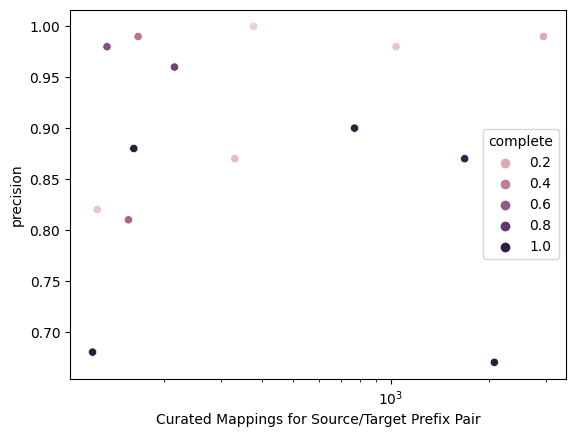

In [12]:
ax = sns.scatterplot(
    data=scenario_df,
    x="curated",
    y="precision",
    hue="complete",
    # hue=scenario_df["predicted"].map(lambda v: "Biased" if v > 0 else "Unbiased"),
)
ax.set_xscale("log")
ax.set_xlabel("Curated Mappings for Source/Target Prefix Pair")
plt.show()

# Remaining Curation Effort

There are a few more low-hanging fruit for exhaustive curation. Additionally, there are some that we don't need to curate like mesh-uniprot that are high-confidence predictions.

In [13]:
pairs_df[pairs_df["predicted"] > 0].reset_index()[
    ["source", "target", "predicted", "complete"]
].sort_values("predicted")

,source,target,predicted,complete
3,doid,efo,39,0.73
2,doid,mesh,55,0.97
10,mesh,uberon,68,0.66
9,mesh,mondo,76,0.74
6,efo,mesh,145,0.52
7,hp,mesh,205,0.45
8,hgnc,mesh,1367,0.08
1,doid,umls,2339,0.09
5,mesh,uniprot,10970,0.03
4,mesh,ncit,11737,0.07
